# Solar Active Regions

In this example, a dataset containing different solar properties are analysed. The goal is to forecast the flux (first column) with the help of previous measurements of the other features. The dataset is significantly harder than the artificially created 'toy_dataset_sine' dataset. However, it is believed to contain more signal than stock market time series, therefore serving as a nice intermediate. The focuss in this example will be on column selection for the different SCINets in the stack and comparing performance with other prediction models. 

As always, we will begin by importing the neccessary libraries:

In [1]:
import os
import sys
import numpy as np
import pandas as pd

from tqdm import tqdm

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR)

### Importing and Visualizing the raw data

Since the data is too large to be stored on Github, the data for this example has to be separately downloaded, which can be done here: insert link!. It should then be placed under datasets in the SAR folder with names 'SAR_train.npy' and 'SAR_test.npy'. Only then can the data be loaded in: 

In [2]:
data_train = np.load(BASE_DIR + '/datasets/SAR/SAR_train.npy')
data_test = np.load(BASE_DIR + '/datasets/SAR/SAR_test.npy')

print('Number of features: {}'.format(data_train.shape[2]))
print('Number of training samples: {}'.format(data_train.shape[0]))
print('Number of test samples: {}'.format(data_test.shape[0]))
print('Length of each sample: {}'.format(data_test.shape[1]))


Number of features: 16
Number of training samples: 23951
Number of test samples: 10670
Length of each sample: 200


Immediatly, to prevent any data leakage from the labels to the data, the samples are split into a data and label component:

In [14]:
X_len = 168
Y_len = 32

X_train = data_train[:,:X_len,:]
y_train = data_train[:,X_len:X_len+Y_len,:]
X_val = data_test[:data_test.shape[0]//2,:X_len,:]
y_val = data_test[:data_test.shape[0]//2,X_len:X_len+Y_len,:]
X_test = data_test[data_test.shape[0]//2:,:X_len,:]
y_test = data_test[data_test.shape[0]//2:,X_len:X_len+Y_len,:]

The first thing we will do is plot histograms of the distributions of the different features. This gives us a good initial feel for the data:

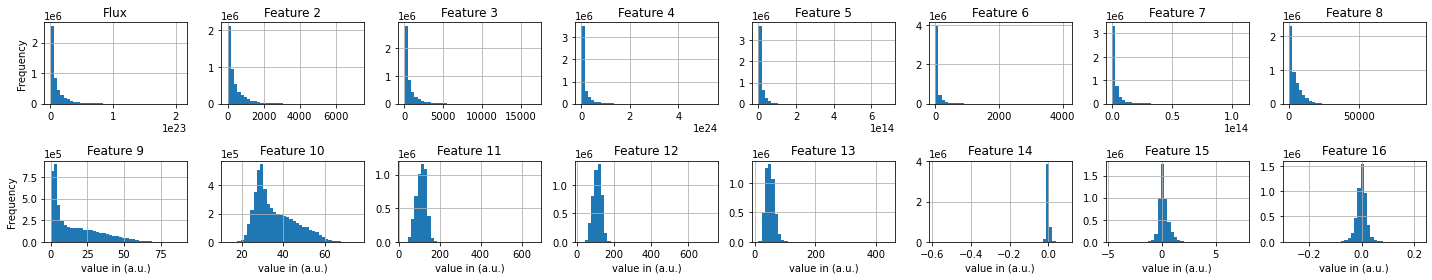

In [4]:
from utils.plotting import plot_histograms

ncols = data_train.shape[2]//2

plot_histograms(ncols, data_train)



Besides observing that the features vary wildly in order of magnitude (and should therefore certainly be standardized), we also remark that a lot of the distributions, especially those of the upper row are heavily skewed to the left. As such, before training, applying a logarithmic function to counteract this is required.

In addition, the number of features we have is quite high for multivariate time series analysis. As such, it is interesting to know which are correlated most with the flux such that we can prioritize these. As such, the mean pearson correlation coefficient between the first and consequent columns is computed. Of course, this does not take into account non-linear interactions but hopefully it grants us a rough estimate:

100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


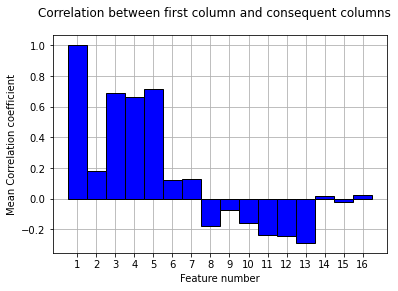

In [5]:
from scipy.stats import pearsonr

from utils.plotting import barplot_correlations

mean_correlations = []

for i in tqdm(range(X_train.shape[2])):
    correlations = []

    for j in range(X_train.shape[0]):
        correlations.append(pearsonr(X_train[j,:,0],X_train[j,:,i])[0])

    mean_correlations.append(np.mean(correlations))

barplot_correlations(X_train.shape[2], mean_correlations)

There are strong positive correlations between features 3,4,5 and feature 1 (of course the correlation with itself is 1). In addition, features 11,12 and 13 show some negative correlation with the flux. As such, we will remark these columns as being more promising than the others.

### Preprocessing the data

Because the data is already divided into samples, the data only has to be normalized. As previously mentioned, we also apply a log-function to deal with skewed data. Fortunately, all of this can be handled by the standardize function from the 'preprocessing_data.py' from the base:

In [15]:
from base.preprocess_data import standardize

standardization_settings = {
                    'per_sample': False,
                    'leaky': False,
                    'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                    'sqrt_val': 2, #of course only if mode is sqrt
}

X_train_proc, y_train_proc, X_val_proc, y_val_proc, X_test_proc, y_test_proc, mean, std = \
    standardize(standardization_settings, [[X_train,y_train],[X_val, y_val],[X_test,y_test]], X_len, Y_len) 

### Training



In [17]:
from base.train_scinet import train_scinet

n_epochs = 50
n_features = 16
n_features_list = np.arange(n_features)

results = train_scinet(
            X_train= X_train_proc,
            y_train= y_train_proc,
            X_val= X_val_proc,
            y_val= y_val_proc,
            X_test= X_test_proc,
            y_test= y_test_proc,
            epochs = n_epochs,
            batch_size = 64,
            X_LEN = X_len,
            Y_LEN = [Y_len,Y_len],
            output_dim = [n_features, 1],
            selected_columns = [n_features_list,[0]],
            hid_size= 128,
            num_levels= 2,
            kernel = 5,
            dropout = 0.3,
            loss_weights= [0.3,0.3,0.4],
            learning_rate = 0.005,
            probabilistic = False,
            )

model = results[0]
history = results[1]

===========================[SCINET]=====================================
Initializing training with data:
X_train: (23951, 168, 16), y_train: (23951, 32, 16)
X_val: (5335, 168, 16), y_val: (5335, 32, 16)
X_test: (5335, 168, 16), y_test: (5335, 32, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 168, 16)]    0           []                               
                                                                                                  
 Block_0 (SCINet)               (None, 32, 16)       7403200     ['input_4[0][0]']                
                                                                                                  
 tf.compat.v1.gather_1 (TFOpLam  (None, 168, 16)     0           ['input_4[0][0]']                
 bda)                                   